## 实验：二值化图像修复

### 实验概要

在胶卷拍摄年代，大多数人家里都会存放有放一些旧的退化照片，上面会存有有一些黑点，甚至一些笔画等。你有没有想过恢复它？我们不能简单地在绘画工具中擦除它们，因为它将简单地用白色结构替换黑色结构，这是没有用的，照片可能会变得更糟。在这些情况下，我们可以尝试采用图像修复的技术来实现照片修复。基本思路很简单：先从图像中提取划痕，划痕移除后，通过图像插值算法，用邻近的像素替换那些划痕被移除后的空白像素，使其看起来像是一幅完整的图像。目前，数字修复算法在图像插值，照片恢复，缩放和超分辨率等方面具有广泛的应用。

<img src="./img/album.jpg">

#### 形态学处理

在前面的实验中，我们通过阈值化分割可以得到二值图，但往往会出现图像中物体形态不完整，变的残缺 —— 或者从视觉效果上而言就是齿痕感很重，不自然。我们可以通过形态学处理，使其变得丰满，或者去除掉多余的像素。常用的形态学处理算法包括：腐蚀，膨胀，开运算，闭运算，形态学梯度，顶帽运算和底帽运算。因此，完整的形态学处理需要三个元素： 

1. 原始图像
2. 一个被称为结构化元素或 **核**，它是用来决定操作的性质的。它实际上是一个由 `0`，`1` 组成的矩阵。譬如下面这个 5x5 的十字形核：

```python
>>> import cv2
>>> element = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
>>> element
array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)
```

3. 具体的算法

首先，我们通过 `kernel=cv2.getStructuringElement(shape, ksize, anchor)` 得到核，其中：

- **shape**: 核的形状
  - *`cv2.MORPH_RECT`:* 矩形
  - *`cv2.MORPH_CROSS`:* 十字形 (以矩形的锚点为中心的十字架)
  - *`cv2.MORPH_ELLIPSE`:* 椭圆 (矩形的内切椭圆）
                
- **ksize**: 核的大小，矩形的宽，高格式为 (width, height)
- **anchor**: 核的锚点，默认值为 (-1,-1)，即核的中心点

由于我们当前做形态学操作的图像是二值化的，也就是图片在表示上只有 `0`，`1`；同时，我们定义的结构化元素或 **核** 也只有 `0`，`1`；让这个核，从你图像的左上角开始滑动，滑完整个图片。在滑动的过程中实现与或运算。

最后，指定形态学处理算法执行运算。

- **腐蚀**：操作类似于中值平滑，也有一个核，但不进行卷积运算，而是取核中像素值的最小值代替锚点位置的像素值，这样就会使图像中较暗的区域面积增大，较亮的的区域面积减小。如果是一张黑底，白色前景的二值图，就会使白色的前景物体颜色变小，就像被腐蚀了一样。进行腐蚀操作的核，不仅可以是矩形，还可以是十字形和椭圆形。OpenCV 提供 `erode()` 函数进行腐蚀操作。
- **膨胀**：操作和腐蚀操作正好相反，是取核中像素值的最大值代替锚点位置的像素值，这样会使图像中较亮的区域增大，较暗的区域减小。如果是一张黑底，白色前景的二值图，就会使白色的前景物体颜色面积变大，就像膨胀了一样。OpenCV 提供 `dilate()` 函数进行膨胀操作。
- **开运算**：先进行腐蚀操作，后进行膨胀操作，主要用来去除一些较亮的部分，即先腐蚀掉不要的部分，再进行膨胀。
- **闭运算**：先进行膨胀操作，后进行腐蚀操作，主要用来去除一些较暗的部分。
- **形态学梯度**：膨胀运算结果减去腐蚀运算结果，可以拿到轮廓信息。
- **顶帽运算**：原图像减去开运算结果。
- **底帽运算**：原图像减去闭运算结果。　　

进行开运算，闭运算，顶帽运算，底帽运算，形态学梯度，OpenCV 提供统一的函数 `cv2.morphologyEx()`。

### 实验目标

在本实验中，我们尝试使用图像二值化技术，从一张被划有笔画划痕的照片中将划痕提取出来。

之后，通过 OpenCV 的 `cv2.inpaint()` 函数，分别采用 INPAINT_TELEA 与 INPAINT_NS 算法对图像实现修复。

### 1. 导入 OpenCV 库

In [1]:
import cv2

# 加载matplotlib.pyplot进行图像显示
import matplotlib.pyplot as plt 
%matplotlib inline

### 2. 加载并显示损毁图像

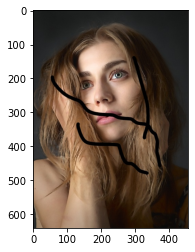

In [2]:
# 设置输入输出路径
import os
base_path = os.environ.get("BASE_PATH",'../data/')
data_path = os.path.join(base_path + "lab2/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)

src = cv2.imread("./data/Inkedlena-new_LI.jpg")
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 提取划痕

首先，我们将图像转换为灰度图像，从下面的输出可以清晰的看到划痕与周边像素之间的差异。

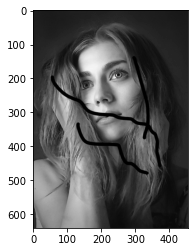

In [3]:
#图像转换为灰度图像
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# 显示灰度图像
plt.imshow(gray, cmap='gray')
plt.show()

#### 3.1 执行图像二值化 

通过阈值设置，将划痕从图像中提取出来，你可以尝试调整阈值，对比掩码输出，从而获得最为理想的提取划痕的效果。

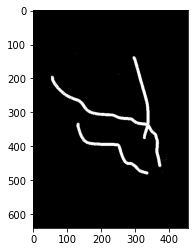

In [11]:
# 执行图像二值化 (<3的像素点全部转换为255(白))
th, mask = cv2.threshold(gray, 3, 255, cv2.THRESH_BINARY_INV)

# 显示掩码
# 将图像转换为 RGB 模式显示
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)) 
plt.show()

#### 3.2 二值掩码形态学处理

True

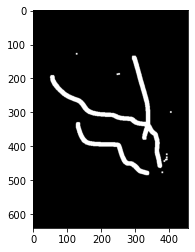

In [13]:
# 生成 5x5 的矩形核进行滑动
se = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  
# 使用矩形核对掩码执行膨胀操作
mask_inpaint = cv2.dilate(mask, se)                     
mask_erode = cv2.erode(mask,se)

# 将图像转换为 RGB 模式显示
plt.imshow(cv2.cvtColor(mask_inpaint, cv2.COLOR_BGR2RGB)) 
cv2.imwrite(result_path+"mask_inpaint.png", mask)

True

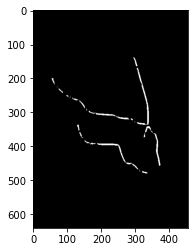

In [14]:
# 将图像转换为 RGB 模式显示
plt.imshow(cv2.cvtColor(mask_erode, cv2.COLOR_BGR2RGB)) 
cv2.imwrite(result_path+"mask_erode.png", mask)

#### <font color="#0000dd">练习题</font>

> - **<font color="#0000dd">尝试采用其他形态学处理算法，测试不同算法对提取出来的划痕掩码图像的影响。</font>**

### 4. 图像修复

使用 `cv2.inpaint()` 实现图像修复：

```python
dst = cv2.inpaint（src，mask, inpaintRadius，flags）
```
- **dst**：返回值，输出与 `src` 具有相同大小和类型的图像。
- **src**：输入 8 位 1 通道或 3 通道图像。
- **inpaintMask**：修复掩码，8 位 1 通道图像。非零像素表示需要修复的区域。
- **inpaintRadius**：算法考虑的每个点的圆形邻域的半径。
- **flags**：修复算法
  - INPAINT_TELEA
  - INPAINT_NS

#### 4.1 INPAINT_TELEA 算法

INPAINT_TELEA 算法基于 Alexandru Telea 于 2004 年发表的 《[An Image Inpainting Technique Based on the Fast Marching Method](https://www.researchgate.net/publication/238183352_An_Image_Inpainting_Technique_Based_on_the_Fast_Marching_Method)》 论文实现。它基于快速行进方法 (FFM)。考虑图像中要修复的区域。算法从该区域的边界开始，然后进入区域内，逐渐填充边界中的所有内容。它需要在邻近的像素周围的一个小邻域进行修复。该像素由邻居中所有已知像素的归一化加权和代替。选择权重是一个重要的问题。对于靠近该点的那些像素，靠近边界的法线和位于边界轮廓上的像素，给予更多的权重。一旦像素被修复，它将使用快速行进方法移动到下一个最近的像素。 FMM 确保首先修复已知像素附近的像素，这样它就像手动启发式操作一样工作。

<img src="./img/INPAINT_TELEA.png">

使用 `cv2.INPAINT_TELEA` 参数使用此算法。

True

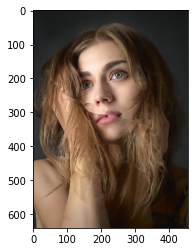

In [6]:
# 消除划痕
# 3为领域大小
result_TELEA = cv2.inpaint(src, mask_inpaint, 3, cv2.INPAINT_TELEA) 

# 将图像转换为 RGB 模式显示
plt.imshow(cv2.cvtColor(result_TELEA, cv2.COLOR_BGR2RGB)) 
# 显示并输出修复结果
cv2.imwrite(result_path+"result_TELEA.png", result_TELEA)      

#### 4.2 INPAINT_NS 算法

INPAINT_NS 算法基于Bertalmio 等人于 2001 年发表的 《[Navier-Stokes, fluid dynamics, and image and video inpainting](https://www.researchgate.net/publication/3940597_Navier-Stokes_fluid_dynamics_and_image_and_video_inpainting)》论文。该算法基于流体动力学并利用了偏微分方程。基本原理是启发式的。它首先沿着边缘从已知区域移动到未知区域（因为边缘是连续的）。它延续了等距线（线连接具有相同强度的点，就像轮廓线连接具有相同高程的点一样），同时在修复区域的边界匹配梯度矢量。为此，使用了一些流体动力学方法。获得它们后，将填充颜色以减少该区域的最小差异。

<img src="./img/INPAINT_NS.png">

使用 `cv2.INPAINT_NS` 参数启用此算法。

True

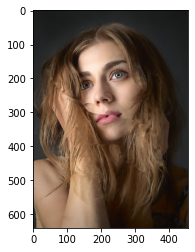

In [7]:
# 消除划痕
# 3为领域大小
result_NS = cv2.inpaint(src, mask_inpaint, 3, cv2.INPAINT_NS) 

# 将图像转换为 RGB 模式显示
plt.imshow(cv2.cvtColor(result_NS, cv2.COLOR_BGR2RGB)) 
# 显示并输出修复结果
cv2.imwrite(result_path+"result_NS.png", result_NS)         

### 实验小结

在本实验中，你实现了使用图像二值化技术，从一张被划有笔画划痕的照片中将划痕提取出来。之后，通过 OpenCV 的 `cv2.inpaint()` 函数，分别采用 INPAINT_TELEA 与 INPAINT_NS 算法对图像实现修复。由于基于像素插值技术，修复效果与图像的构图、划痕的形态、颜色都有紧密的关系。近年来，图像修复的技术热点，逐步转移到通过生成对抗网络 (GAN) 技术实现。